# Preparing the Environment for Exploratory Data Analysis

In [1]:
# Imports of Models & libraries. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
import nltk
import os
import string   
import re

from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import column_or_1d
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob
from scipy.stats import norm
from collections import Counter
from nltk import PorterStemmer
from scipy.ndimage import gaussian_gradient_magnitude
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import warnings
warnings.filterwarnings('ignore')

# Setting up a date parser using a private funciton, lambda
# This will give us the dates in a format we require for aggregation & indexation
d_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

In [2]:
# Load the CSV file(s).
counts = pd.read_csv('Bicycle_Counts.csv', parse_dates=['date'], date_parser=d_parser)
parking = pd.read_csv('Bicycle_Parking.csv')
routes = pd.read_excel('Bicycle_Routes.xlsx')

In [3]:
# View the DataFrame, metadata, shape
counts.info()
parking.info()
routes.info()

# Counts is a large but simple Df containing the number of bicycles passing through a counter
# Parking contains geographic details of bicycle racks in the city of NY
# Routes contains geographic details of list of bike lanes and routes in the city of NY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4167507 entries, 0 to 4167506
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      int64         
 1   date    datetime64[ns]
 2   counts  int64         
 3   status  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 127.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30178 entries, 0 to 30177
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   BoroCode    30178 non-null  int64 
 1   BoroName    30178 non-null  object
 2   CounDist    30178 non-null  int64 
 3   AssemDist   30178 non-null  int64 
 4   StSenDist   30178 non-null  int64 
 5   CongDist    30178 non-null  int64 
 6   STREETON    17710 non-null  object
 7   XSTREET1    21881 non-null  object
 8   XSTREET2    21771 non-null  object
 9   SIDE        18395 non-null  object
 10  ASSETSUBTY  30178 non-null  object
dtypes: int64(5), object(6)
memo

## EDA on Counts DataFrame

### Data  Wrangling

In [4]:
# Check for missing values in counts
counts.isnull().sum()

# No missing values

id        0
date      0
counts    0
status    0
dtype: int64

In [5]:
# Make sure that the data is sorted in cbronological order without altering anything else for the moment
counts.sort_values(by='date')

# Can see data set runs from 31 Aug 2012 to 04 Jul 2022
# Can extract hour of the day to look for patterns. Expect peak vs off peak patterns
# We can also group the data by day of the week to look for patterns within that
# We can also see that its possible to group the data into month to look for seasonal patterns
# We can also group/subset the data by id which is another spatial/location identifier

,id,date,counts,status
2059019,100047029,2012-08-31 00:00:00,41,4
3205445,100062893,2012-08-31 00:00:00,41,4
4164087,100005020,2012-08-31 00:00:00,41,4
2370586,100051865,2012-08-31 00:00:00,41,4
4165734,100005020,2012-08-31 00:15:00,52,4
...,...,...,...,...
16707,100062893,2022-07-04 23:45:00,34,0
16803,300020241,2022-07-04 23:45:00,16,0
16995,300024007,2022-07-04 23:45:00,2,0
16323,100047029,2022-07-04 23:45:00,34,0


In [6]:
# Extract year information from timestamped date column
counts['year'] = counts['date'].dt.year

In [7]:
# Define night and day to calculate user defined peak and off peak hours
# Extract hour information first from timestamped date column
counts['hour'] = counts['date'].dt.hour

In [8]:
# Create user defined function for peak and off peak hours
def f(x):
    if (x > 5) and (x <= 7):
        return 'Early Morning'
    elif (x > 7) and (x <= 10 ):
        return 'Peak Morning'
    elif (x > 11) and (x <= 16):
        return'Off Peak/Noon'
    elif (x > 16) and (x <= 19) :
        return 'Peak Eve'
    elif (x > 19) and (x <= 23):
        return'Night'
    elif (x <= 5):
        return'Late Night'

# Apply user defined function to create new column with peak and off peak hours
counts['time_of_day'] = counts['hour'].apply(f)

In [9]:
# Define day of the week and add as column
counts = counts.assign(day_of_week = lambda x: x.date.dt.day_name())

In [10]:
# Define month to calculate user defined seasons
# Extract month information first from timestamped date column
counts['month'] = counts['date'].dt.month

In [11]:
# Create user defined function for seasons
def f(x):
    if (x > 1) and (x <= 2):
        return 'Winter'
    elif (x > 2) and (x <= 5 ):
        return 'Spring'
    elif (x > 5) and (x <= 8):
        return'Summer'
    elif (x > 8) and (x <= 11) :
        return 'Autumn'
    elif (x > 11):
        return'Winter'

# Apply user defined function to create new column with seasons
counts['season'] = counts['month'].apply(f)

In [12]:
# Look at 10 rows randomly to ensure all user defined columns correctly populated
counts.sample(10)

,id,date,counts,status,year,hour,time_of_day,day_of_week,month,season
1076775,100010017,2021-11-21 17:15:00,5,0,2021,17,Peak Eve,Sunday,11,Autumn
3521203,100009426,2013-12-27 16:15:00,1,0,2013,16,Off Peak/Noon,Friday,12,Winter
255465,100009427,2020-08-18 07:45:00,86,0,2020,7,Early Morning,Tuesday,8,Summer
1958350,100010022,2020-01-24 16:00:00,16,0,2020,16,Off Peak/Noon,Friday,1,None
2537887,100051865,2017-11-09 22:15:00,43,4,2017,22,Night,Thursday,11,Autumn
1063231,100010017,2021-07-17 17:30:00,4,0,2021,17,Peak Eve,Saturday,7,Summer
2243846,100047029,2018-10-30 09:45:00,124,0,2018,9,Peak Morning,Tuesday,10,Autumn
1648345,100010020,2017-04-04 01:00:00,1,0,2017,1,Late Night,Tuesday,4,Spring
1357225,100010019,2017-11-03 04:00:00,0,0,2017,4,Late Night,Friday,11,Autumn
3541636,300020241,2021-10-11 01:15:00,6,0,2021,1,Late Night,Monday,10,Autumn


### Creating Visualisations: How has cycling uptake evolved over time?

In [13]:
# Aggregate data by year
df=counts.groupby(['year'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('year', inplace=True)

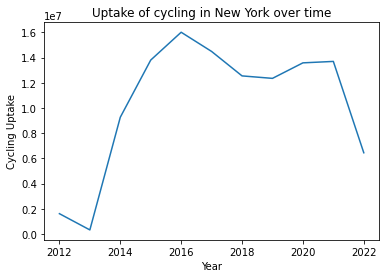

In [14]:
#Creating the line chart
plt.plot(df['year'], df['counts']) 
#Adding the aesthetics
plt.title('Uptake of cycling in New York over time')
plt.xlabel('Year')
plt.ylabel('Cycling Uptake') 
#Show the plot
plt.show()

# Interesting that peak was 2016
# Sharp decline in mid 2020 due to COVID-19
# 2022 data still not showing uptake pickup although data is not for full year in 2022

### Creating Data Visualisations : Does time of the day Matter?

In [15]:
# Aggregate data by time of day
df=counts.groupby(['time_of_day'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)

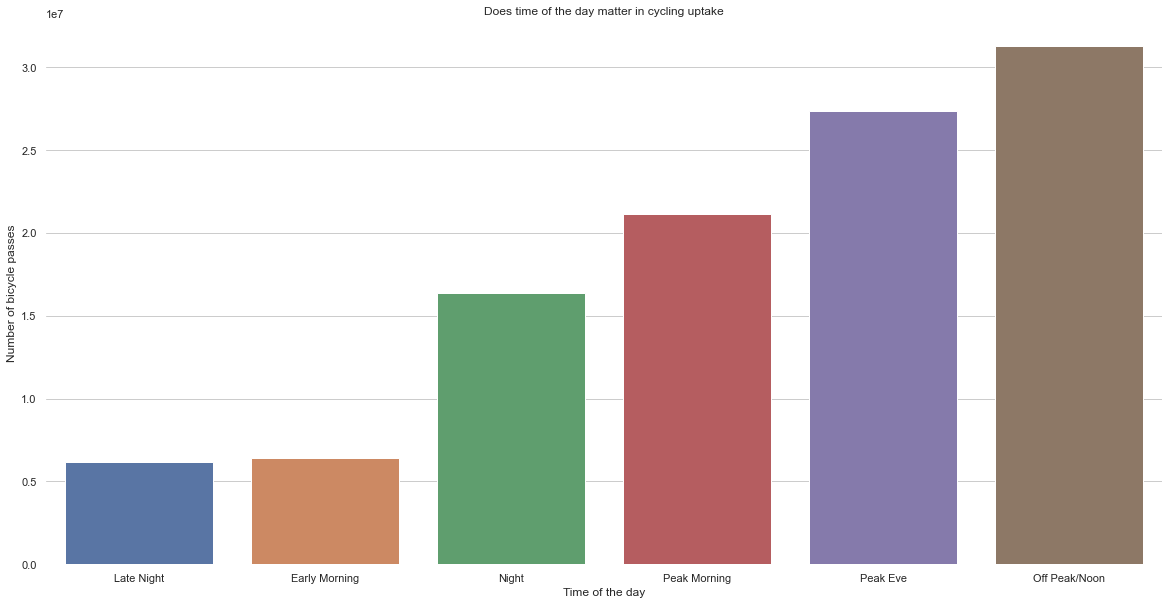

In [16]:
# Visualise to see which time of day has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(20, 10))

g=sns.barplot(x = df["time_of_day"], y = df["counts"])

# Add a legend and informative axis label
g.set(ylabel="Number of bicycle passes",
       xlabel="Time of the day")
g.set_title('Does time of the day matter in cycling uptake')
sns.despine(left=True, bottom=True)
plt.show()

# Surprisingly peak hours dont show highest use!
# So are cyclists more leisure users than commuters?
# Need to explore why more are not cycling during peak hours.

### Creating Data Visualisations: Does Day of the Week matter?

In [17]:
# Aggregate data by time of day
df=counts.groupby(['day_of_week'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)

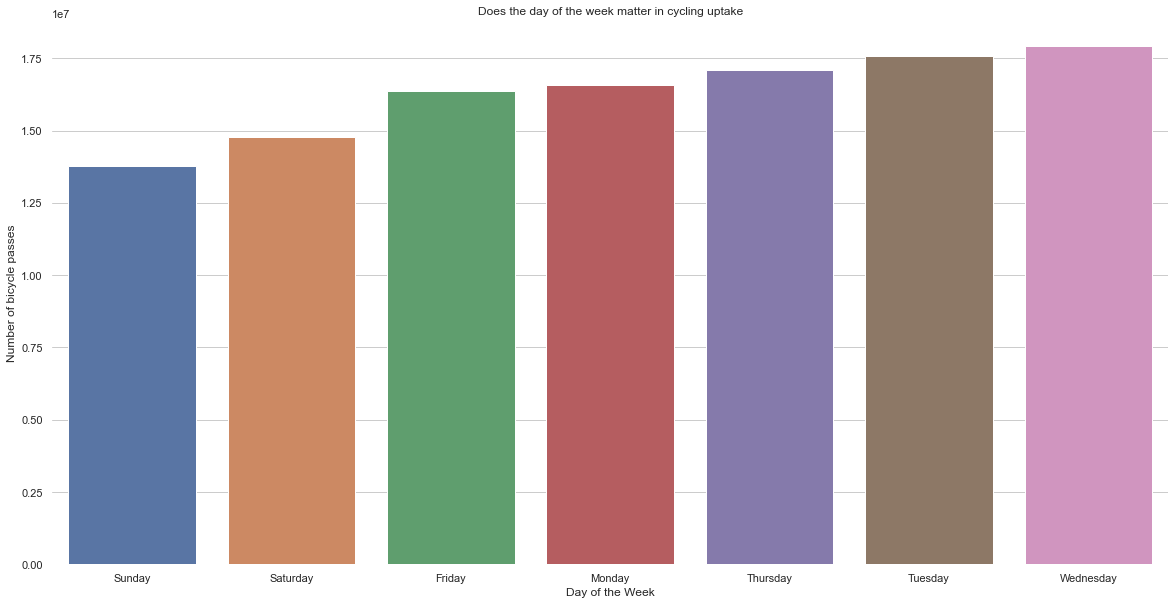

In [18]:
# Visualise to see which time of day has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(20, 10))

g=sns.barplot(x = df["day_of_week"], y = df["counts"])

# Add a legend and informative axis label
g.set(ylabel="Number of bicycle passes",
       xlabel="Day of the Week")
g.set_title('Does the day of the week matter in cycling uptake')
sns.despine(left=True, bottom=True)
plt.show()

# Except weekends, not big differences
# Mid week days Tuesday & Wednesdays shows greatest number
# Will be interesting to see how these compare with the other cities

### Creating Data Visualisations: Do seasons matter?

In [19]:
# Aggregate data by time of day
df=counts.groupby(['season'], as_index=False)['counts'].sum()

# Sort by Values
df.sort_values('counts', inplace=True)

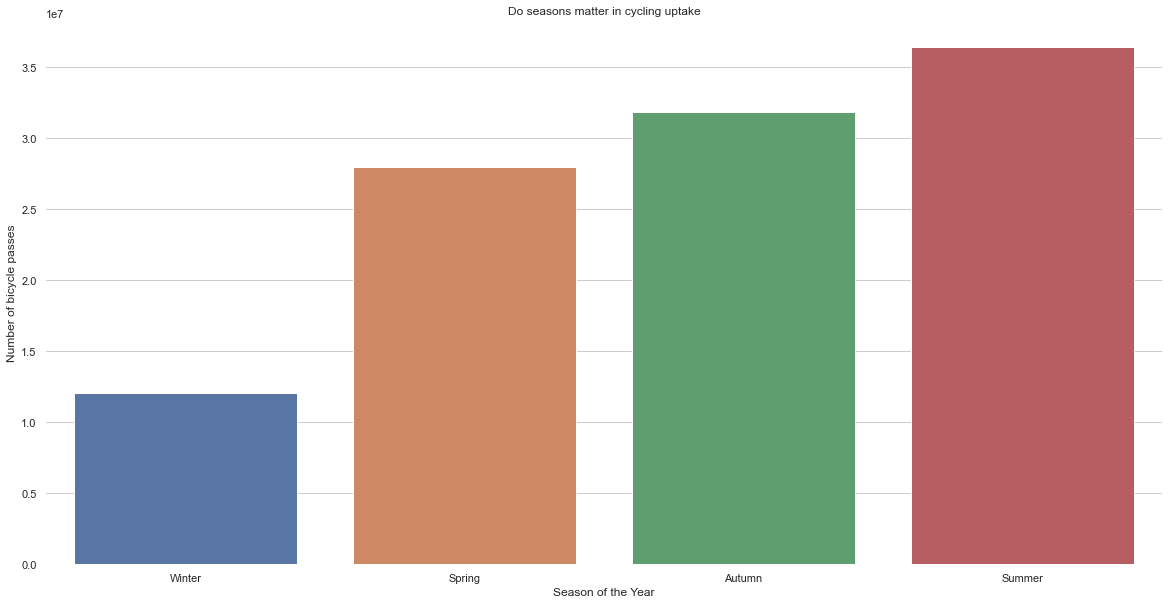

In [20]:
# Visualise to see which time of day has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(20, 10))

g=sns.barplot(x = df["season"], y = df["counts"])

# Add a legend and informative axis label
g.set(ylabel="Number of bicycle passes",
       xlabel="Season of the Year")
g.set_title('Do seasons matter in cycling uptake')
sns.despine(left=True, bottom=True)
plt.show()

# Unsurprising but combined with time of the day, may suggest that there is a safety concern issue

### Creating Data Visualisations: Does location matter?

In [21]:
# Count the number of unique values for id
print(counts.nunique())

# Shows 25 spatial/locational data

id                 25
date           344996
counts            939
status              2
year               11
hour               24
time_of_day         6
day_of_week         7
month              12
season              4
dtype: int64


In [22]:
# Group by Spatial ID
df=counts.groupby(['id'], as_index=False)['counts'].sum()

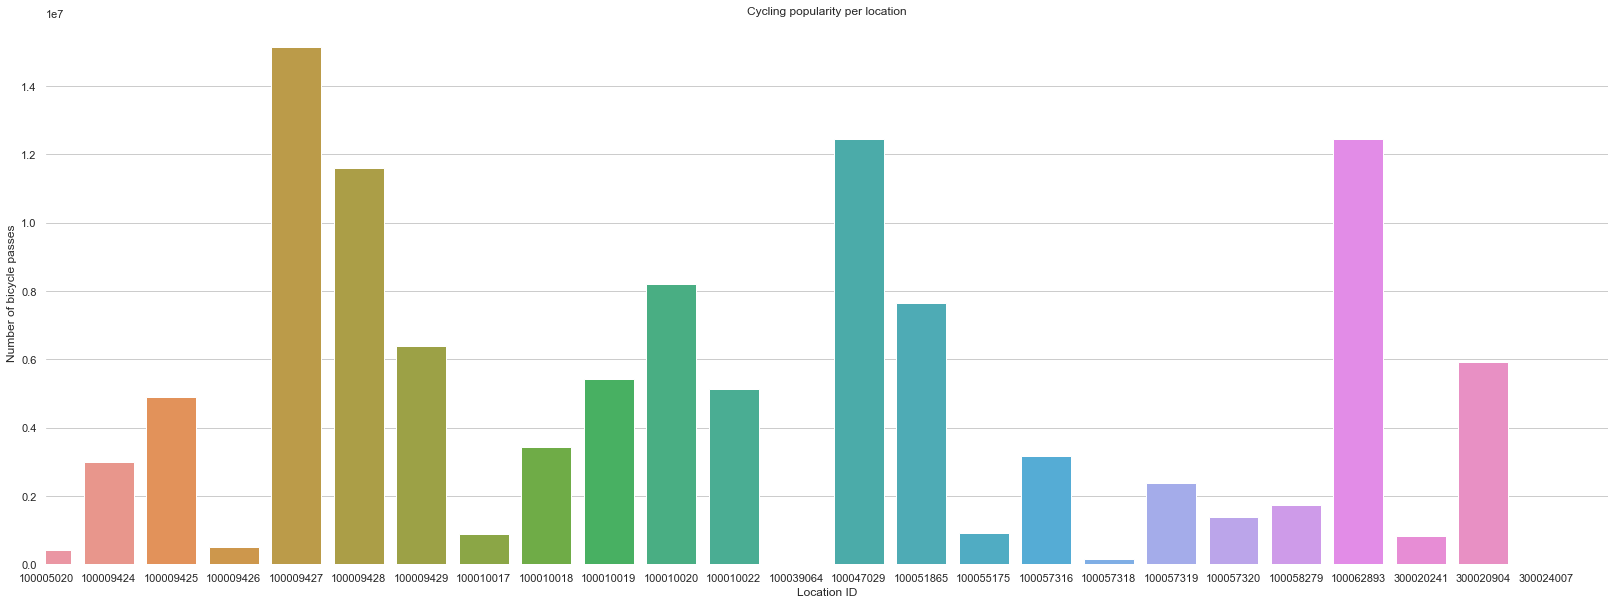

In [23]:
# Visualise to see which location has the highest count of cycling
sns.set_theme(style="whitegrid")
from matplotlib.ticker import FormatStrFormatter

# Initialize the matplotlib figure
f, g = plt.subplots(figsize=(28, 10))

g=sns.barplot(x = df["id"], y = df["counts"])

# Add a legend and informative axis label
g.set(xlim=(0, 25), ylabel="Number of bicycle passes",
       xlabel="Location ID")
g.set_title('Cycling popularity per location')
sns.despine(left=True, bottom=True)
plt.show()

# Number of Cycle passes varies considerably by location
# Potential to drill down for further analysis on these locations versus time of day, week etc.
# Discuss with team how to best represent this

## EDA on Parking DataFrame

### Data Wrangling

In [24]:
# Check for missing values in parking
parking.isnull().sum()

# Lots of missing values in several columns
# Looks like address/geographical data
# Makes sense there are missing values
# Not all columns required/available to complete an address

BoroCode          0
BoroName          0
CounDist          0
AssemDist         0
StSenDist         0
CongDist          0
STREETON      12468
XSTREET1       8297
XSTREET2       8407
SIDE          11783
ASSETSUBTY        0
dtype: int64

In [25]:
# View dataframe parking
parking.sample(10)

,BoroCode,BoroName,CounDist,AssemDist,StSenDist,CongDist,STREETON,XSTREET1,XSTREET2,SIDE,ASSETSUBTY
19846,3,Brooklyn,34,50,18,7,NaN,BEDFORD AV,BERRY ST,NaN,U-Rack
9932,3,Brooklyn,44,48,17,10,NEW UTRECHT AV,NaN,NaN,NaN,Large Hoop
19419,4,Queens,28,38,10,5,105 ST,LIBERTY AV,103 AV,W,Small Hoop
15762,3,Brooklyn,33,52,25,8,SCHERMERHORN ST,HOYT ST,BOND ST,N,Large Hoop
19992,3,Brooklyn,40,44,17,9,WESTMINSTER RD,CONEY ISLAND AV,WESTMINSTER RD,W,Large Hoop
12230,3,Brooklyn,37,53,18,7,WYCKOFF AV,HARMAN ST,GREENE AV,NaN,Large Hoop
21726,3,Brooklyn,33,50,18,12,NaN,BEDFORD AV,BERRY ST,W,Wave Rack
27875,3,Brooklyn,36,57,25,8,Bedford Avenue,Putnam Avenue,Madison Street,W,LARGE HOOP
658,3,Brooklyn,37,54,18,7,CORNELIA ST,CORNELIA ST,PUTNAM AV,NaN,Large Hoop
13049,3,Brooklyn,34,53,18,7,MORGAN AV,JOHNSON AV,INGRAHAM ST,E,Large Hoop


In [26]:
# Count the number of unique values for each column
print(parking.nunique())

# How to marry this with counts data which has 25 unique location ids?

BoroCode         5
BoroName         5
CounDist        51
AssemDist       65
StSenDist       26
CongDist        13
STREETON      1671
XSTREET1      2608
XSTREET2      2724
SIDE             4
ASSETSUBTY      11
dtype: int64


## EDA on Routes DataFrame

### Data Wrangling

In [27]:
# Check for missing values
routes.isnull().sum()

# Missing value in just one column
# Looks like geographic location details again

segmentid        0
boro             0
street           0
fromstreet       0
tostreet         0
bikedir          0
lanecount        0
ft_facilit    5394
dtype: int64

In [28]:
# View dataframe
routes.sample(10)

,segmentid,boro,street,fromstreet,tostreet,bikedir,lanecount,ft_facilit
16452,301.507,1,EAST RIVER ESPLANADE,SOUTH ST,OLD SLIP,2,2,Greenway
10773,159.051,1,ADAM C POWELL BLVD,W 133 ST,W 150 ST,L,1,NaN
11147,164.076,3,UNION AV,CONSELYEA ST,MEEKER AV,2,2,Sharrows
9704,150.38,3,SURF AV,OCEAN PKWY,W 17 ST,R,1,Signed Route
12552,214.748,4,SHORE FRONT PKWY,BEACH 73,SHORE FRONT PKWY,R,1,Curbside
10482,157.616,3,CROPSEY AVE,24 AVE,26 AVE,L,1,NaN
14380,243.908,1,HARLEM RIVER DR GREENWAY,W 155 ST,10 AV,2,2,Greenway
7056,96.467,4,73 AV,MAIN ST,199 ST,2,2,Standard
9786,150.935,3,EMMONS AV,SHORE BLVD,KNAPP ST,R,1,Signed Route
9133,146.28,3,AV W,BRAGG ST,NOSTRAND AV,R,1,Standard


In [29]:
# Count the number of unique values for each column
print(routes.nunique())

# Boro in routes will merge with borocode in parking
# Still cant figure out how to marry these with counts dataframe.

segmentid     20792
boro              5
street         1292
fromstreet     1478
tostreet       1496
bikedir           3
lanecount         4
ft_facilit       14
dtype: int64


# Outlier Detection

In [ ]:
# Worth looking for outliers using K-Means Clustering in the count data
# Otherwise data was pre-wrangled and looks to be good shape
# Not sure how many of the columns contain useful data in the two geospatial dataframes
# Need to explore how to look for outliers in geospatial data. 
# Discuss with team

## Counts DataFrame

In [ ]:
# Data Visualisation to determine clusters
plt.figure(figsize=(8,6))
plt.scatter(counts.date, counts.counts)
plt.xlabel('Date')
plt.ylabel('Counts')
plt.title('Scatter plot of Date vs. Count')
plt.show()

# Vis is not clear. 
# Need to run alternative clustering check

In [ ]:
# Create a pairplot
# Create a pairplot between variables with Seaborn.
x = counts[['date', 'counts']]
sns.pairplot(counts, vars=x, hue='status', diag_kind='kde')

# Better output but still not particularly revealing
# Try a statistical method to explore if any clusters within the data can be identified

In [ ]:
# Use Violinplots to both visualise outliers and their quality
# Remove unnecessary columns & standardise the data to reduce scalar effects
counts2 = counts.drop(['date', 'id', 'status'], axis=1)
# Standardise
ss = StandardScaler()
counts2 = pd.DataFrame(ss.fit_transform(counts2), columns=['counts'])

# Set out the plot.
g=sns.violinplot(data=counts2, showmedians=True, showmeans=True)
g.set_title('Detecting Outliers in New York Counts')

# Show plot
plt.show()

# Very long tail
# Discuss with team how to deal with this.

In [ ]:
# Try a boxplot
g=sns.boxplot(data=counts2)
g.set_title('Boxplot of New Counts')
plt.show()

# Data Analysis